# Zero Noise Extrapolation with QsimCirq

## I. Import Library

1. Import classical libraries

In [1]:
import sys
sys.path.append("../Help Functions")
import extrapolation

import time
import tracemalloc
import itertools

import numpy as np
import matplotlib.pyplot as plt
import csv

2. Import quantum libraries

In [2]:
import cirq
import qsimcirq
from functools import lru_cache

## II. Help functions for simulation

1. Create ideal GHZ circuit

In [3]:
def create_GHZ_circuit(num_qubits):
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()

    circuit.append(cirq.H(qubits[0]))
    for i in range(num_qubits - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))

    return circuit, qubits

5. Create noisy GHZ circuit that return density matrix

In [4]:
def create_noisy_GHZ(num_qubits, p):
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()

    circuit.append(cirq.H(qubits[0]))
    circuit.append(cirq.DepolarizingChannel(p).on(qubits[0]))

    for i in range(num_qubits - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
        circuit.append(cirq.DepolarizingChannel(p).on(qubits[i]))
        circuit.append(cirq.DepolarizingChannel(p).on(qubits[i+1]))

    return circuit, qubits

6. Fidelity between ideal GHZ circuit vs noise GHZ circuit

In [5]:
def fidelity_ideal_noise(ideal_circuit, noise_circuit):
    sim_ideal = qsimcirq.QSimSimulator()
    result_ideal = sim_ideal.simulate(ideal_circuit)
    psi_ideal = result_ideal.final_state_vector

    sim_noisy = cirq.DensityMatrixSimulator()
    result_noisy = sim_noisy.simulate(noise_circuit)
    rho_noisy = result_noisy.final_density_matrix

    fidelity = cirq.qis.fidelity(rho_noisy, psi_ideal)
    return fidelity

## III. Circuit folding and gate folding

1. Folding circuit

In [6]:
def folding_circuit(num_qubits, p, n):
    ghz_circuit, qubits = create_noisy_GHZ(num_qubits, p)
    circuit = cirq.Circuit()
    circuit += ghz_circuit

    for _ in range(n):
        # H gate + entangling forward
        circuit.append(cirq.H(qubits[0]))
        circuit.append(cirq.DepolarizingChannel(p).on(qubits[0]))
        for i in range(num_qubits - 1):
            circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
            circuit.append(cirq.DepolarizingChannel(p).on(qubits[i]))
            circuit.append(cirq.DepolarizingChannel(p).on(qubits[i+1]))
        for i in reversed(range(num_qubits - 1)):
            circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
            circuit.append(cirq.DepolarizingChannel(p).on(qubits[i]))
            circuit.append(cirq.DepolarizingChannel(p).on(qubits[i+1]))
        circuit.append(cirq.H(qubits[0]))
        circuit.append(cirq.DepolarizingChannel(p).on(qubits[0]))
    
    return circuit

2. Folding gate

In [7]:
def folding_gate(num_qubits, p, n):
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()

    for _ in range(n):
        circuit.append([cirq.H(qubits[0]),cirq.DepolarizingChannel(p).on(qubits[0]), 
                        cirq.H(qubits[0]), cirq.DepolarizingChannel(p).on(qubits[0])])
    circuit.append(cirq.H(qubits[0]))
    circuit.append(cirq.DepolarizingChannel(p).on(qubits[0]))

    for i in range(num_qubits - 1):
        for _ in range(n):
            circuit.append([cirq.CNOT(qubits[i], qubits[i+1]), cirq.DepolarizingChannel(p).on(qubits[i]), cirq.DepolarizingChannel(p).on(qubits[i+1]),
                            cirq.CNOT(qubits[i], qubits[i+1]), cirq.DepolarizingChannel(p).on(qubits[i]), cirq.DepolarizingChannel(p).on(qubits[i+1])])
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
        circuit.append(cirq.DepolarizingChannel(p).on(qubits[i]))
        circuit.append(cirq.DepolarizingChannel(p).on(qubits[i+1]))

    return circuit

## IV. Run experiment

1. Set up

In [8]:
qubit_sizes = list(range(2, 11))
noise = 0.02

## V. Run Code

In [9]:
circuit_results = []

max_num_fold = 4
stretch = [2*i + 1 for i in range(max_num_fold + 1)]

for num_qubits in qubit_sizes:
    print(f"\nRunning scalability test for {num_qubits} qubits...")

    ideal_ghz_circuit = create_GHZ_circuit(num_qubits)

    start = time.time()
    tracemalloc.start()

    noise_circuit = create_noisy_GHZ(num_qubits, noise)
    fidelity_before_ZNE = fidelity_ideal_noise(ideal_ghz_circuit[0], noise_circuit[0])

    _, peak_mem_base = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = time.time()

    time_exec_base = end - start

    print(f"  Fidelity before ZNE: {fidelity_before_ZNE:.4f}")
    
    # Circuit folding

    qubit_fidelities = []
    
    start = time.time()
    tracemalloc.start()

    for i in range(0, max_num_fold + 1):
        if i==2:
            start_fold = time.time()
            before = tracemalloc.take_snapshot()

            noise_circuit= folding_circuit(num_qubits, noise, i)
            fidelity = fidelity_ideal_noise(ideal_ghz_circuit[0], noise_circuit)

            after = tracemalloc.take_snapshot()
            end_fold = time.time()

            stats = after.compare_to(before, 'lineno')
            peak_mem_fold = sum(stat.size_diff for stat in stats if stat.size_diff > 0)
            time_exec_fold = end_fold - start_fold
        else:
            noise_circuit= folding_circuit(num_qubits, noise, i)
            fidelity = fidelity_ideal_noise(ideal_ghz_circuit[0], noise_circuit)
        qubit_fidelities.append(fidelity)

    _, peak_mem_overall = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    zero_expo_fidelity = extrapolation.exponential_extrapolation(stretch, qubit_fidelities) 

    end = time.time()

    time_exec_overall = end - start

    circuit_results.append((num_qubits, fidelity_before_ZNE, zero_expo_fidelity, 
                            time_exec_base, peak_mem_base/1024/1024, 
                            time_exec_fold, peak_mem_fold/1024/1024, 
                            time_exec_overall, peak_mem_overall/1024/1024))

    print("\n------------------------------------------Circuit Folding------------------------------------------")
    print(f"  Extrapolated zero-noise fidelity with Exponential fidelity: {zero_expo_fidelity:.4f}")

    print(f"  Peak Memory Usage Baseline Circuit = {peak_mem_base/1024/1024:.2f} MB")
    print(f"  Execution Time Baseline Circuit: {time_exec_base:.4f} sec")

    print(f"  Peak Memory Usage 2 folds = {peak_mem_fold/1024/1024:.2f} MB")
    print(f"  Execution Time 2 folds: {time_exec_fold:.4f} sec")

    print(f"  Peak Memory Usage Overall (no baseline) = {peak_mem_overall/1024/1024:.2f} MB")
    print(f"  Execution Time Overall (no baseline): {time_exec_overall:.4f} sec")


Running scalability test for 2 qubits...
  Fidelity before ZNE: 0.9479

------------------------------------------Circuit Folding------------------------------------------
  Extrapolated zero-noise fidelity with Exponential fidelity: 0.9949
  Peak Memory Usage Baseline Circuit = 0.15 MB
  Execution Time Baseline Circuit: 0.0260 sec
  Peak Memory Usage 2 folds = 0.03 MB
  Execution Time 2 folds: 0.0786 sec
  Peak Memory Usage Overall (no baseline) = 0.22 MB
  Execution Time Overall (no baseline): 0.3895 sec

Running scalability test for 3 qubits...
  Fidelity before ZNE: 0.9107

------------------------------------------Circuit Folding------------------------------------------
  Extrapolated zero-noise fidelity with Exponential fidelity: 0.9886
  Peak Memory Usage Baseline Circuit = 0.04 MB
  Execution Time Baseline Circuit: 0.0277 sec
  Peak Memory Usage 2 folds = 0.04 MB
  Execution Time 2 folds: 0.1222 sec
  Peak Memory Usage Overall (no baseline) = 0.28 MB
  Execution Time Overall 

## VI. Plot scalability results

1. Graph comparing fidelity before and after ZNE (circuit folding & gate folding) using exponential extrapolation

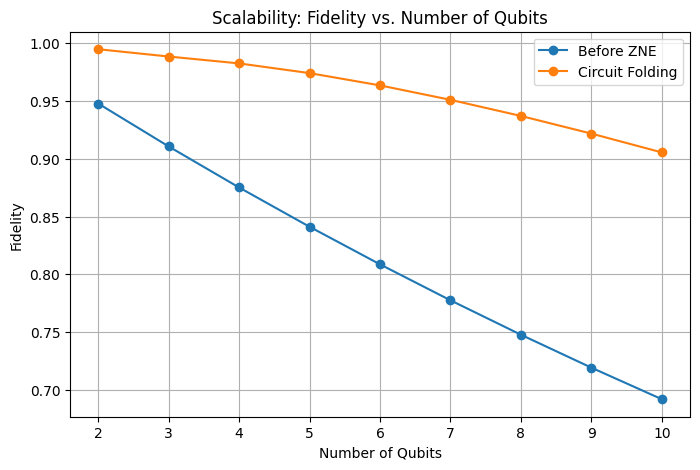

In [10]:
num_qubits_list, fidelities_before, fidelities_exp_circuit, time_base, mem_base, time_circ_fold, mem_circ_fold, time_overall_circ, mem_overall_circ = zip(*circuit_results)

plt.figure(figsize=(8, 5))

plt.plot(num_qubits_list, fidelities_before, 'o-', label="Before ZNE")
plt.plot(num_qubits_list, fidelities_exp_circuit, 'o-', label="Circuit Folding")

plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.legend()
plt.title("Scalability: Fidelity vs. Number of Qubits")
plt.grid()
plt.show()

## VI. Collect Data

In [11]:
platform = "qsimcirq"
start_qubits = 2

datasets = {
    "../Record Data/Memory Usage/baseline.csv": mem_base,
    "../Record Data/Memory Usage/fold2_circuit.csv": mem_circ_fold,
    "../Record Data/Memory Usage/overall_fold_circuit.csv": mem_overall_circ,
    "../Record Data/Time Execution/baseline.csv": time_base,
    "../Record Data/Time Execution/fold2_circuit.csv": time_circ_fold,
    "../Record Data/Time Execution/overall_fold_circuit.csv": time_overall_circ,
}

for filepath, values in datasets.items():
    try:
        with open(filepath, "r") as f:
            lines = f.readlines()
        with open(filepath, "w") as f:
            for line in lines:
                if platform not in line:
                    f.write(line)
    except FileNotFoundError:
        pass

    with open(filepath, mode="a", newline="") as file:
        writer = csv.writer(file)
        for i, t in enumerate(values):
            writer.writerow([platform, start_qubits + i, t])
